In [1]:
YOUR_NAME = 'sara'

AWS_PROFILE = 'cities'

In [2]:
%load_ext autoreload

In [3]:
MAIN_PATH = "s3://wri-cities-sandbox/identifyingLandSubdivisions/data"
INPUT_PATH = f'{MAIN_PATH}/input'
CITY_INFO_PATH = f'{INPUT_PATH}/city_info'
EXTENTS_PATH = f'{CITY_INFO_PATH}/extents'
BUILDINGS_PATH = f'{INPUT_PATH}/buildings'
BLOCKS_PATH = f'{INPUT_PATH}/blocks'
ROADS_PATH = f'{INPUT_PATH}/roads'
INTERSECTIONS_PATH = f'{INPUT_PATH}/intersections'
GRIDS_PATH = f'{INPUT_PATH}/city_info/grids'
SEARCH_BUFFER_PATH = f'{INPUT_PATH}/city_info/search_buffers'
OUTPUT_PATH = f'{MAIN_PATH}/output'
OUTPUT_PATH_CSV = f'{OUTPUT_PATH}/csv'
OUTPUT_PATH_RASTER = f'{OUTPUT_PATH}/raster'
OUTPUT_PATH_PNG = f'{OUTPUT_PATH}/png'
OUTPUT_PATH_RAW = f'{OUTPUT_PATH}/raw_results'

In [1]:
# Check s3 connection using AWS_PROFILE=CitiesUserPermissionSet profile 
import boto3
boto3.setup_default_session(profile_name='cities')
session = boto3.Session(profile_name=AWS_PROFILE)
s3 = session.client('s3')

# export CitiesUserPermissionSet profile to use in the next cells
import os
os.environ['AWS_PROFILE'] = AWS_PROFILE

s3.list_buckets()

NameError: name 'AWS_PROFILE' is not defined

In [5]:
# START COILED CLIENT.

import coiled

cluster = coiled.Cluster(
    workspace="wri-cities-data",
    name=f'ils-{YOUR_NAME}',
    region="us-west-2",
    arm=True,
    worker_vm_types="r8g.xlarge",
    spot_policy="spot",
    n_workers=10,
    package_sync_ignore=["pyspark", "pypandoc",
                         "boto3",
                        "botocore",
                        "aiobotocore",
                        "urllib3"]
)
client = cluster.get_client()

print(f"Started a new Dask client on Coiled. Dashboard is available at {client.dashboard_link}")

[2025-12-17 16:02:24,167][INFO    ][coiled] Fetching latest package priorities...
[2025-12-17 16:02:24,168][INFO    ][coiled.package_sync] Resolving your local subdivisions2 Python environment...
[2025-12-17 16:02:24,517][INFO    ][coiled.package_sync] Scanning 446 conda packages...
[2025-12-17 16:02:24,522][INFO    ][coiled.package_sync] Scanning 261 python packages...
[2025-12-17 16:02:24,946][INFO    ][coiled.software_utils] No username or password found for https://conda.anaconda.org/conda-forge
[2025-12-17 16:02:25,457][INFO    ][coiled] Running pip check...
[2025-12-17 16:02:25,897][INFO    ][coiled] Validating environment...
[2025-12-17 16:02:29,459][INFO    ][coiled] Creating wheel for ~/Documents/Identifying Land Subdivisions/identifyingLandSubdivisions...
[2025-12-17 16:02:29,543][INFO    ][coiled] Creating wheel for /opt/spark-2.2.0/python...
[2025-12-17 16:02:29,697][WARNING ][coiled.package_sync] Package - debugpy, debugpy~=1.8.16 has no install candidate for Python 3.12 l

Started a new Dask client on Coiled. Dashboard is available at https://cluster-fhjpu.dask.host/7SwRXNoV_t55s4Kg/status


/opt/anaconda3/envs/subdivisions2/lib/python3.12/site-packages/distributed/client.py:1590: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | Client | Scheduler | Workers |
+---------+--------+-----------+---------+
| lz4     | 4.4.4  | 4.4.5     | 4.4.5   |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


2025-12-17 16:24:11,207 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
/opt/anaconda3/envs/subdivisions2/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [6]:
import dask_geopandas as dgpd
import dask.dataframe as dd
import pandas as pd
from dask import delayed, compute, visualize
import geopandas as gpd
from dask.diagnostics import ProgressBar
from shapely.geometry import MultiLineString, LineString, Point
from shapely.ops import polygonize, nearest_points
#from shapely.geometry import Polygon, LineString, Point, MultiPolygon, MultiLineString, GeometryCollection
from scipy.optimize import fminbound, minimize
#from unused_code.metrics_groupby import metrics
from dask import delayed
import dask_geopandas as dgpd
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkb
from scipy.stats import entropy
import time
from dask import compute
import matplotlib.pyplot as plt

import s3fs
import os
import shutil

from pre_processing import *
from auxiliary_functions import *
from standardize_metrics import *
from metrics_calculation import *

import time

YOUR_NAME = 'sara'
grid_size = 200

In [7]:
def read_validation_set_s3(bucket_prefix = "wri-cities-sandbox/identifyingLandSubdivisions/data/validation/Land_Use",
                           base = "Sub_Saharan_9_cities_and_LAC_3_cities_Land_use"):
    
    fs = s3fs.S3FileSystem(anon=False)

    # All components of the shapefile
    suffixes = [".shp", ".dbf", ".shx", ".prj", ".cpg"]

    local_dir = "/tmp/land_use"
    os.makedirs(local_dir, exist_ok=True)

    for suf in suffixes:
        s3_path = f"{bucket_prefix}/{base}{suf}"
        local_path = os.path.join(local_dir, base + suf)
        with fs.open(s3_path, "rb") as fsrc, open(local_path, "wb") as fdst:
            shutil.copyfileobj(fsrc, fdst)

    # Now read from local path
    local_shp = os.path.join(local_dir, base + ".shp")
    validation_set = gpd.read_file(local_shp)

    return validation_set

validation_set = read_validation_set_s3()

In [8]:
MAIN_PATH = "s3://wri-cities-sandbox/identifyingLandSubdivisions/data"
OUTPUT_PATH = f"{MAIN_PATH}/output"
OUTPUT_PATH_RASTER = f"{OUTPUT_PATH}/raster"


cities = ["Accra", "Abidjan", "Bamako", "Bogota", "Belo_Horizonte", "Campinas", "Cape_Town", "Lagos",  "Nairobi", "Luanda"]


dfs = []
for city_name in cities:
    out_file = f"{city_name}_all_block_metrics_{YOUR_NAME}.geoparquet"
    remote = f"{OUTPUT_PATH_RASTER}/{city_name}/{out_file}"
    df_tmp = gpd.read_parquet(remote).to_crs(epsg=4326)
    df_tmp["city_name"] = city_name
    dfs.append(df_tmp)


all_cities = pd.concat(dfs)


In [9]:
all_cities['k_complexity_raw'].describe()

count    339690.000000
mean          2.319712
std           1.087955
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          49.000000
Name: k_complexity_raw, dtype: float64

In [10]:
summary = (
    all_cities
    .groupby('city_name')['k_complexity_raw']
    .describe()
)
summary

,count,mean,std,min,25%,50%,75%,max
city_name,,,,,,,,
Abidjan,19910.0,2.234505,0.962872,1.0,2.0,2.0,3.0,14.0
Accra,42356.0,2.467254,1.010949,1.0,2.0,2.0,3.0,23.0
Bamako,44146.0,1.490305,0.765586,1.0,1.0,1.0,2.0,11.0
Belo_Horizonte,28405.0,2.434008,0.903676,1.0,2.0,2.0,3.0,14.0
Bogota,28615.0,2.955233,1.405583,1.0,2.0,3.0,4.0,17.0
Campinas,27153.0,2.383494,1.002789,1.0,2.0,2.0,3.0,18.0
Cape_Town,23120.0,2.485640,1.087767,1.0,2.0,2.0,3.0,30.0
Lagos,44249.0,2.668422,0.974117,1.0,2.0,3.0,3.0,49.0
Luanda,62464.0,2.069976,0.928612,1.0,1.0,2.0,2.0,15.0


/var/folders/nn/3mdkp6sx1n3d955f3wqgdbb00000gn/T/ipykernel_88860/1974236939.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


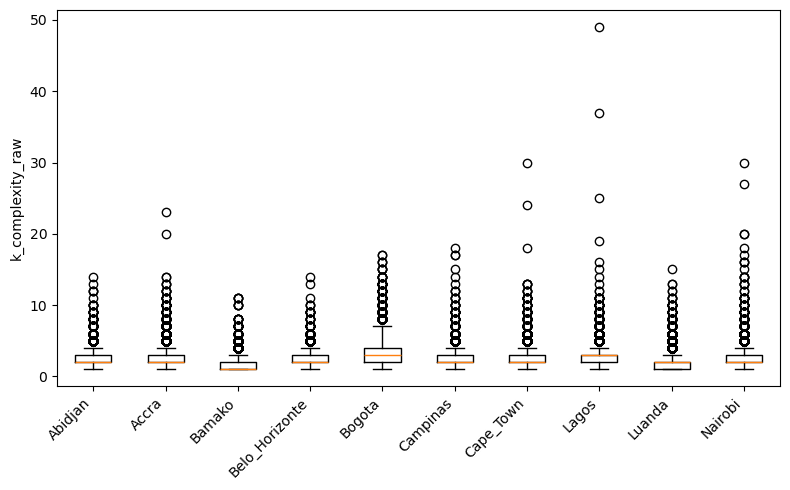

In [11]:
groups = all_cities.groupby('city_name')['k_complexity_raw']

plt.figure(figsize=(max(8, len(groups) * 0.6), 5))

plt.boxplot(
    [g.dropna().values for _, g in groups],
    labels=groups.groups.keys()
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("k_complexity_raw")
plt.tight_layout()
plt.show()


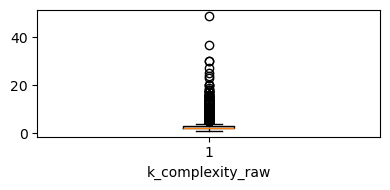

In [12]:


plt.figure(figsize=(4, 2))

plt.boxplot(
    all_cities['k_complexity_raw'].dropna(),
    
    vert=True
)

plt.xlabel("k_complexity_raw")
plt.tight_layout()
plt.show()


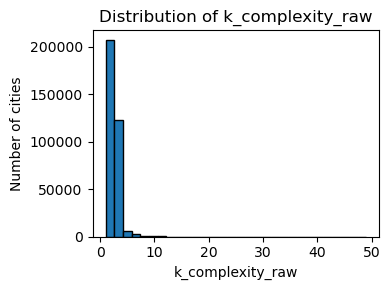

In [13]:
plt.figure(figsize=(4, 3))

plt.hist(
    all_cities['k_complexity_raw'].dropna(),
    bins=30,
    edgecolor="black"
)

plt.xlabel("k_complexity_raw")
plt.ylabel("Number of cities")
plt.title("Distribution of k_complexity_raw")
plt.tight_layout()
plt.show()


In [14]:
all_cities[['k_complexity_raw']].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,k_complexity_raw
0.25,2.0
0.50,2.0
0.75,3.0
0.90,4.0
0.95,4.0
0.99,6.0


In [15]:
all_cities.intersects(validation_set).sum()

/var/folders/nn/3mdkp6sx1n3d955f3wqgdbb00000gn/T/ipykernel_88860/1614086806.py:1: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  all_cities.intersects(validation_set).sum()


np.int64(0)

In [16]:
validation_set

,City_Name,Label,geometry
0,Bogota,1113,"POLYGON ((-74.10426 4.48752, -74.10407 4.48801..."
1,Bogota,1403,"POLYGON ((-74.08751 4.5007, -74.08738 4.50097,..."
2,Bogota,1323,"POLYGON ((-74.23047 4.59043, -74.23028 4.59048..."
3,Bogota,1112,"POLYGON ((-74.1188 4.78324, -74.11888 4.78314,..."
4,Bogota,1112,"POLYGON ((-74.15702 4.53552, -74.15709 4.5362,..."
...,...,...,...
1681,Luanda,1322,"POLYGON ((13.38873 -9.06373, 13.38745 -9.06385..."
1682,Nairobi,1312,"POLYGON ((36.99712 -1.30682, 36.99634 -1.30437..."
1683,Mogadishu,1113,"POLYGON ((45.40937 2.08019, 45.40911 2.08099, ..."
1684,Mogadishu,1403,"POLYGON ((45.40654 2.07919, 45.40633 2.07969, ..."


In [17]:


def area_weight_blocks_to_validation(
    all_cities: gpd.GeoDataFrame,
    validation_set: gpd.GeoDataFrame,
    label_col: str = "Label",
    equal_area_epsg: int = 6933,   # World Cylindrical Equal Area
):
    # ---- pick numeric metric columns from all_cities ----
    metric_cols = [
        c for c in all_cities.columns
        if c not in ["geometry",'city_name']
        and pd.api.types.is_numeric_dtype(all_cities[c])
    ]

    # ---- clean + project to equal-area for correct weights ----
    blocks = all_cities.copy()
    val = validation_set.copy()

    blocks = blocks[blocks.geometry.notnull()].copy()
    val = val[val.geometry.notnull()].copy()

    # fix invalid geoms (optional but often necessary)
    blocks["geometry"] = blocks.geometry.make_valid()
    val["geometry"] = val.geometry.make_valid()

    blocks = blocks.to_crs(epsg=equal_area_epsg)
    val = val.to_crs(epsg=equal_area_epsg)

    # ensure stable id for validation polygons
    if "validation_id" not in val.columns:
        val = val.reset_index(drop=True)
        val["validation_id"] = val.index.astype("int64")

    # polygon area for weights
    val["val_area"] = val.geometry.area

    # ---- candidate matches (touching/intersects) ----
    pairs = gpd.sjoin(
        blocks[["geometry"] + ["city_name"] + metric_cols],
        val[["validation_id", label_col, "val_area", "geometry"]],
        predicate="intersects",
        how="inner",
    )

    # ---- intersection area + weights ----
    # (compute intersection only for matched pairs)
    left_geom = pairs.geometry
    val_geom = val.set_index("validation_id").geometry

    right_geom = gpd.GeoSeries(
        pairs["validation_id"].map(val_geom),
        index=pairs.index,
        crs=val.crs,
    )

    inter_area = pairs.geometry.intersection(right_geom).area


    pairs["inter_area"] = inter_area
    pairs = pairs[pairs["inter_area"] > 0].copy()  # drop pure touches (zero area)

    pairs["w"] = pairs["inter_area"] / pairs["val_area"]

    # ---- weighted aggregation per validation polygon ----
    out = val[["validation_id", label_col, "geometry", "val_area"]].copy()

    # coverage diagnostics (how much of validation polygon is covered by blocks)
    cov = pairs.groupby("validation_id")["inter_area"].sum()
    out["covered_area"] = out["validation_id"].map(cov).fillna(0.0)
    out["coverage_frac"] = (out["covered_area"] / out["val_area"]).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    dominant_city = (
        pairs.groupby(["validation_id", "city_name"])["inter_area"]
            .sum()
            .reset_index()
            .sort_values(["validation_id", "inter_area"], ascending=[True, False])
            .drop_duplicates("validation_id")
            .set_index("validation_id")["city_name"]
    )

    out["city_name"] = out["validation_id"].map(dominant_city)


    # area-weighted means over the validation polygon area (Σ metric * w)
    for c in metric_cols:
        out[c] = pairs.groupby("validation_id").apply(lambda g: (g[c] * g["w"]).sum())

    return gpd.GeoDataFrame(out, geometry="geometry", crs=val.crs).to_crs(epsg=4326)


In [18]:
all_cities.columns

Index(['geometry', 'on_network_street_length', 'off_network_street_length',
       'nearest_external_street', 'building_count', 'building_layers',
       'k_complexity', 'optimal_point', 'max_radius', 'n_buildings',
       'sum_distance', 'n_closer_20m', 'has_buildings',
       'average_distance_nearest_building', 'm1_raw', 'm1_std', 'm2_raw',
       'm2_std', 'block_area', 'block_area_km2', 'built_area', 'index',
       'total_len_m', 'road_length', 'has_roads', 'n_intersections',
       'intersections_3plus', 'intersections_4way', 'has_intersections',
       'm3_raw', 'm3_std', 'm4_raw', 'm4_std', 'm5_raw', 'm5_std', 'm10_raw',
       'm10_std', 'm11_raw', 'm11_std', 'm12_raw', 'm12_std', 'm6_raw',
       'm6_std', 'm7_raw', 'm7_std', 'm8_raw', 'm8_std', 'm9_raw', 'm9_std',
       'k_complexity_raw', 'k_complexity_std', 'm1_final', 'm2_final',
       'm3_final', 'm4_final', 'm5_final', 'm10_final', 'm11_final',
       'm12_final', 'm6_final', 'm7_final', 'm8_final', 'm9_final',
     

In [19]:
agg_to_validation = area_weight_blocks_to_validation(all_cities, validation_set, label_col="Label")
agg_to_validation['label_category'] = agg_to_validation['Label'].apply(lambda x: x[:2])

subdivisions_dict = {
    11: 'Subdivision',
    13: 'Hybrid',
    14: 'Irregular Settlement',
    20: 'Non Residential',
    10: 'Open Area'
}

agg_to_validation['label_cat_subdivision_irregular'] = agg_to_validation['label_category'].apply(lambda x: subdivisions_dict[int(x)])


/var/folders/nn/3mdkp6sx1n3d955f3wqgdbb00000gn/T/ipykernel_88860/698798918.py:85: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out[c] = pairs.groupby("validation_id").apply(lambda g: (g[c] * g["w"]).sum())
/var/folders/nn/3mdkp6sx1n3d955f3wqgdbb00000gn/T/ipykernel_88860/698798918.py:85: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out[c] = pairs.groupby("validation_id").apply(lambda g: (g[c] * g["w"]).sum())
/var/f

In [20]:
agg_to_validation['city_name']

0          Bogota
1          Bogota
2          Bogota
3          Bogota
4          Bogota
          ...    
1681       Luanda
1682      Nairobi
1683          NaN
1684          NaN
1685    Cape_Town
Name: city_name, Length: 1686, dtype: object

In [21]:
agg_to_validation.groupby("Label")[['m1_std', 'm2_std', 'm3_std',
                                           'm4_std','m5_std', 'm6_std','m7_std','m8_std','m9_std',
                                            'm10_std','m11_std','m12_std']].mean()


#'on_network_street_length', 'off_network_street_length', 'nearest_external_street', 'building_count', 'building_layers', 'k_complexity', 
# 'optimal_point', 'max_radius', 'n_buildings', 'sum_distance', 'n_closer_20m', 'has_buildings', 'average_distance_nearest_building', 
# 'm1_raw', 'm1_std', 'm2_raw', 'm2_std', 'block_area', 'block_area_km2', 'built_area', 'index', 'total_len_m', 'road_length', 'has_roads', 
# 'n_intersections', 'intersections_3plus', 'intersections_4way', 'has_intersections', 'm3_raw', 'm3_std', 'm4_raw', 'm4_std', 'm5_raw', 'm5_std', 
# 'm10_raw', 'm10_std', 'm11_raw', 'm11_std', 'm12_raw', 'm12_std', 'm6_raw', 'm6_std', 'm7_raw', 'm7_std', 'm8_raw', 'm8_std', 'm9_raw', 'm9_std'

,m1_std,m2_std,m3_std,m4_std,m5_std,m6_std,m7_std,m8_std,m9_std,m10_std,m11_std,m12_std
Label,,,,,,,,,,,,
1000,0.453183,0.537654,0.447852,0.112601,0.157933,0.433896,0.078914,0.845793,0.464469,0.752328,0.837319,0.446074
1111,0.579002,0.637026,0.590963,0.209823,0.347266,0.574399,0.303104,0.887296,0.627941,0.825090,0.884250,0.394473
1112,0.621059,0.667225,0.695350,0.169884,0.406710,0.545299,0.388322,0.817790,0.544677,0.631245,0.757639,0.445130
1113,0.692388,0.709487,0.734564,0.177372,0.457618,0.598072,0.430111,0.891419,0.451314,0.531952,0.737022,0.560595
1121,0.417103,0.490998,0.464046,0.178364,0.213117,0.454379,0.188507,0.813030,0.509541,0.763792,0.819509,0.346452
1122,0.658932,0.765253,0.758469,0.218740,0.450459,0.603275,0.364391,0.908367,0.689194,0.688048,0.847554,0.412186
1123,0.744268,0.794427,0.740417,0.222673,0.504607,0.595207,0.462164,0.937104,0.769681,0.527888,0.793893,0.478650
1311,0.595674,0.718257,0.696193,0.301442,0.353513,0.556570,0.330561,0.890988,0.461414,0.766030,0.853414,0.393998
1312,0.569539,0.710586,0.761189,0.270544,0.434978,0.596170,0.405257,0.906857,0.662427,0.652933,0.824734,0.431648


In [22]:
agg_to_validation.groupby("Label")[['m1_raw','m2_raw','m3_raw', 'm4_raw', 'm5_raw', 'm6_raw', 'm7_raw', 'm8_raw', 'm9_raw',
                                            'm10_raw', 'm11_raw', 'm12_raw']].mean()

,m1_raw,m2_raw,m3_raw,m4_raw,m5_raw,m6_raw,m7_raw,m8_raw,m9_raw,m10_raw,m11_raw,m12_raw
Label,,,,,,,,,,,,
1000,0.453183,40.089259,22.183246,0.112601,57.930258,0.433896,666.320143,0.844109,38.325008,622.211230,0.052984,100.891778
1111,0.579002,30.798309,45.111472,0.209823,156.789694,0.574399,679.798467,0.886109,26.849267,407.266286,0.042017,85.111717
1112,0.621059,19.597835,52.821280,0.169884,177.007593,0.545299,306.539457,0.813531,27.516127,903.013223,0.092773,94.612428
1113,0.692388,25.092145,63.466744,0.177372,221.693276,0.598072,377.399224,0.886151,43.154695,2220.185897,0.193789,152.983899
1121,0.417103,38.363228,31.744853,0.178364,103.838010,0.454379,635.092613,0.812737,30.495978,338.397182,0.028875,69.741741
1122,0.658932,16.971287,55.674481,0.218740,207.741411,0.603275,232.314223,0.908351,22.119503,1038.919563,0.087412,82.685009
1123,0.744268,17.528763,77.938157,0.222673,325.649776,0.595207,354.996742,0.936818,18.003027,2622.140067,0.175822,97.760110
1311,0.595674,19.164291,46.126832,0.301442,151.042259,0.556570,547.089844,0.890983,40.348173,574.787883,0.056313,79.031705
1312,0.569539,21.726996,52.295270,0.270544,190.248635,0.596170,243.299925,0.906032,23.649855,1113.596762,0.100469,95.140770


In [23]:
agg_to_validation.groupby("Label")[['regularity_index']].mean()

,regularity_index
Label,
1000,0.448860
1111,0.561085
1112,0.551800
1113,0.578599
1121,0.460414
1122,0.608643
1123,0.612184
1311,0.580579
1312,0.598042


In [24]:
agg_to_validation['label_cat_subdivision_irregular']

0                Subdivision
1       Irregular Settlement
2                     Hybrid
3                Subdivision
4                Subdivision
                ...         
1681                  Hybrid
1682                  Hybrid
1683             Subdivision
1684    Irregular Settlement
1685    Irregular Settlement
Name: label_cat_subdivision_irregular, Length: 1686, dtype: object

In [25]:
agg_to_validation.groupby("label_category")[['m1_raw','m2_raw','m3_raw', 'm4_raw', 'm5_raw', 'm6_raw', 'm7_raw', 'm8_raw', 'm9_raw',
                                            'm10_raw', 'm11_raw', 'm12_raw','regularity_index']].mean()

,m1_raw,m2_raw,m3_raw,m4_raw,m5_raw,m6_raw,m7_raw,m8_raw,m9_raw,m10_raw,m11_raw,m12_raw,regularity_index
label_category,,,,,,,,,,,,,
10,0.453183,40.089259,22.183246,0.112601,57.930258,0.433896,666.320143,0.844109,38.325008,622.211230,0.052984,100.891778,0.448860
11,0.622840,25.611926,53.891059,0.191474,190.943948,0.568160,450.496051,0.871431,31.228475,1250.252768,0.109182,106.347481,0.562422
13,0.621659,20.582575,54.170215,0.203530,192.054606,0.560815,270.501869,0.918059,24.221512,2248.358356,0.152693,82.390079,0.573013
14,0.420993,37.884999,20.392050,0.108812,54.885356,0.348737,690.479123,0.803586,30.842258,1241.446326,0.069920,72.398765,0.395480
20,0.546282,33.018488,39.633128,0.171024,126.015183,0.533739,460.393304,0.912487,36.805941,1318.745651,0.111513,128.135140,0.538989


In [26]:
agg_to_validation.groupby("label_category")[['m1_raw','m2_raw','m3_raw', 'm4_raw', 'm5_raw', 'm6_raw', 'm7_raw', 'm8_raw', 'm9_raw',
                                            'm10_raw', 'm11_raw', 'm12_raw','regularity_index']].median()

,m1_raw,m2_raw,m3_raw,m4_raw,m5_raw,m6_raw,m7_raw,m8_raw,m9_raw,m10_raw,m11_raw,m12_raw,regularity_index
label_category,,,,,,,,,,,,,
10,0.440981,29.395458,15.988431,0.071429,27.563788,0.390052,396.508076,0.945920,14.434068,343.142285,0.036152,87.177895,0.469632
11,0.671323,15.430441,50.419968,0.140023,142.511263,0.606424,184.530936,0.954761,13.956609,703.247009,0.083367,92.876508,0.600086
13,0.640230,16.614951,51.894340,0.148528,128.181578,0.562255,155.733914,0.969851,10.557909,1279.842754,0.117428,77.780012,0.596308
14,0.419164,27.952040,16.110444,0.075838,28.871136,0.343912,384.225466,0.940103,16.169727,482.509885,0.043197,64.241671,0.428931
20,0.530330,22.600300,31.571635,0.118026,72.110304,0.525026,226.150296,0.964116,12.258913,670.151125,0.085773,100.479809,0.535059


In [27]:
agg_to_validation.groupby("label_category")[['m1_std', 'm2_std', 'm3_std',
                                           'm4_std','m5_std', 'm6_std','m7_std','m8_std','m9_std',
                                            'm10_std','m11_std','m12_std','regularity_index']].mean()

,m1_std,m2_std,m3_std,m4_std,m5_std,m6_std,m7_std,m8_std,m9_std,m10_std,m11_std,m12_std,regularity_index
label_category,,,,,,,,,,,,,
10,0.453183,0.537654,0.447852,0.112601,0.157933,0.433896,0.078914,0.845793,0.464469,0.752328,0.837319,0.446074,0.448860
11,0.622840,0.672525,0.666499,0.191474,0.398021,0.568160,0.361251,0.874115,0.563042,0.661849,0.800842,0.456093,0.562422
13,0.621659,0.739613,0.770092,0.203530,0.438327,0.560815,0.385696,0.918658,0.674191,0.523088,0.790625,0.400357,0.573013
14,0.420993,0.506152,0.421609,0.108812,0.144093,0.348737,0.063476,0.806018,0.509869,0.614300,0.782640,0.353046,0.395480
20,0.546282,0.653156,0.651635,0.171024,0.320681,0.533739,0.225632,0.915373,0.543221,0.682497,0.840663,0.514955,0.538989


In [28]:
agg_to_validation.groupby("label_category")[['m1_std', 'm2_std', 'm3_std',
                                           'm4_std','m5_std', 'm6_std','m7_std','m8_std','m9_std',
                                            'm10_std','m11_std','m12_std','regularity_index']].median()

,m1_std,m2_std,m3_std,m4_std,m5_std,m6_std,m7_std,m8_std,m9_std,m10_std,m11_std,m12_std,regularity_index
label_category,,,,,,,,,,,,,
10,0.440981,0.623421,0.382270,0.071429,0.082737,0.390052,0.000827,0.945920,0.669611,0.877819,0.950950,0.435494,0.469632
11,0.671323,0.787183,0.753411,0.140023,0.383681,0.606424,0.362222,0.954996,0.761295,0.752436,0.876058,0.459951,0.600086
13,0.640230,0.809231,0.873012,0.148528,0.376382,0.562255,0.377373,0.971994,0.856035,0.620128,0.852737,0.378421,0.596308
14,0.419164,0.611620,0.373590,0.075838,0.087515,0.343912,0.000867,0.940272,0.604157,0.794143,0.927823,0.321208,0.428931
20,0.530330,0.744593,0.723603,0.118026,0.213258,0.525026,0.060186,0.964116,0.814588,0.812209,0.899681,0.500729,0.535059


In [29]:
agg_to_validation.groupby("label_cat_subdivision_irregular")[['m1_std', 'm2_std', 'm3_std',
                                           'm4_std','m5_std', 'm6_std','m7_std','m8_std','m9_std',
                                            'm10_std','m11_std','m12_std','regularity_index']].median()

,m1_std,m2_std,m3_std,m4_std,m5_std,m6_std,m7_std,m8_std,m9_std,m10_std,m11_std,m12_std,regularity_index
label_cat_subdivision_irregular,,,,,,,,,,,,,
Hybrid,0.640230,0.809231,0.873012,0.148528,0.376382,0.562255,0.377373,0.971994,0.856035,0.620128,0.852737,0.378421,0.596308
Irregular Settlement,0.419164,0.611620,0.373590,0.075838,0.087515,0.343912,0.000867,0.940272,0.604157,0.794143,0.927823,0.321208,0.428931
Non Residential,0.530330,0.744593,0.723603,0.118026,0.213258,0.525026,0.060186,0.964116,0.814588,0.812209,0.899681,0.500729,0.535059
Open Area,0.440981,0.623421,0.382270,0.071429,0.082737,0.390052,0.000827,0.945920,0.669611,0.877819,0.950950,0.435494,0.469632
Subdivision,0.671323,0.787183,0.753411,0.140023,0.383681,0.606424,0.362222,0.954996,0.761295,0.752436,0.876058,0.459951,0.600086


In [30]:
agg_to_validation.groupby("label_cat_subdivision_irregular")[['m1_raw','m2_raw','m3_raw', 'm4_raw', 'm5_raw', 'm6_raw', 'm7_raw', 'm8_raw', 'm9_raw',
                                            'm10_raw', 'm11_raw', 'm12_raw','regularity_index']].mean()

,m1_raw,m2_raw,m3_raw,m4_raw,m5_raw,m6_raw,m7_raw,m8_raw,m9_raw,m10_raw,m11_raw,m12_raw,regularity_index
label_cat_subdivision_irregular,,,,,,,,,,,,,
Hybrid,0.621659,20.582575,54.170215,0.203530,192.054606,0.560815,270.501869,0.918059,24.221512,2248.358356,0.152693,82.390079,0.573013
Irregular Settlement,0.420993,37.884999,20.392050,0.108812,54.885356,0.348737,690.479123,0.803586,30.842258,1241.446326,0.069920,72.398765,0.395480
Non Residential,0.546282,33.018488,39.633128,0.171024,126.015183,0.533739,460.393304,0.912487,36.805941,1318.745651,0.111513,128.135140,0.538989
Open Area,0.453183,40.089259,22.183246,0.112601,57.930258,0.433896,666.320143,0.844109,38.325008,622.211230,0.052984,100.891778,0.448860
Subdivision,0.622840,25.611926,53.891059,0.191474,190.943948,0.568160,450.496051,0.871431,31.228475,1250.252768,0.109182,106.347481,0.562422


In [31]:
agg_to_validation.groupby("label_cat_subdivision_irregular")[['m1_final','m2_final','m3_final', 'm4_final', 'm5_final', 'm6_final', 'm7_final', 'm8_final', 'm9_final',
                                            'm10_final', 'm11_final', 'm12_final','regularity_index']].mean()

,m1_final,m2_final,m3_final,m4_final,m5_final,m6_final,m7_final,m8_final,m9_final,m10_final,m11_final,m12_final,regularity_index
label_cat_subdivision_irregular,,,,,,,,,,,,,
Hybrid,0.621659,0.739613,0.768132,0.203530,0.438327,0.435519,0.385696,0.778912,0.853610,0.523088,0.789497,0.400357,0.573013
Irregular Settlement,0.420993,0.506152,0.418532,0.108812,0.144093,0.183619,0.063476,0.542281,0.738331,0.614300,0.780748,0.353046,0.395480
Non Residential,0.546282,0.653156,0.650369,0.171024,0.320681,0.396536,0.225632,0.706824,0.815858,0.682497,0.841447,0.514955,0.538989
Open Area,0.453183,0.537654,0.445006,0.112601,0.157933,0.284619,0.078914,0.593574,0.748359,0.752328,0.837912,0.446074,0.448860
Subdivision,0.622840,0.672525,0.665002,0.191474,0.398021,0.456287,0.361251,0.670623,0.794365,0.661849,0.801302,0.456093,0.562422


In [32]:
agg_to_validation.groupby("label_cat_subdivision_irregular")[['m1_final','m2_final','m3_final', 'm4_final', 'm5_final', 'm6_final', 'm7_final', 'm8_final', 'm9_final',
                                            'm10_final', 'm11_final', 'm12_final','k_complexity','regularity_index']].median()

,m1_final,m2_final,m3_final,m4_final,m5_final,m6_final,m7_final,m8_final,m9_final,m10_final,m11_final,m12_final,k_complexity,regularity_index
label_cat_subdivision_irregular,,,,,,,,,,,,,,
Hybrid,0.640230,0.809231,0.873012,0.148528,0.376382,0.419788,0.377373,0.825665,0.952012,0.620128,0.852737,0.378421,2.986426,0.596308
Irregular Settlement,0.419164,0.611620,0.369906,0.075838,0.087515,0.132310,0.000867,0.603920,0.861619,0.794143,0.930642,0.321208,3.993595,0.428931
Non Residential,0.530330,0.744593,0.723603,0.118026,0.213258,0.371253,0.060186,0.767946,0.936927,0.812209,0.903714,0.500729,3.001492,0.535059
Open Area,0.440981,0.623421,0.379659,0.071429,0.082737,0.195171,0.000827,0.642696,0.886167,0.877819,0.948982,0.435494,3.085360,0.469632
Subdivision,0.671323,0.787183,0.753411,0.140023,0.383681,0.486234,0.362222,0.714245,0.909659,0.752436,0.875285,0.459951,2.372730,0.600086


In [33]:
agg_to_validation.groupby("label_cat_subdivision_irregular")[['k_complexity','regularity_index']].median()

,k_complexity,regularity_index
label_cat_subdivision_irregular,,
Hybrid,2.986426,0.596308
Irregular Settlement,3.993595,0.428931
Non Residential,3.001492,0.535059
Open Area,3.085360,0.469632
Subdivision,2.372730,0.600086


In [34]:
agg_to_validation.groupby("label_cat_subdivision_irregular")[['k_complexity','regularity_index']].median()

,k_complexity,regularity_index
label_cat_subdivision_irregular,,
Hybrid,2.986426,0.596308
Irregular Settlement,3.993595,0.428931
Non Residential,3.001492,0.535059
Open Area,3.085360,0.469632
Subdivision,2.372730,0.600086


In [35]:
agg_to_validation.groupby("label_category")[['k_complexity','regularity_index']].median()

,k_complexity,regularity_index
label_category,,
10,3.085360,0.469632
11,2.372730,0.600086
13,2.986426,0.596308
14,3.993595,0.428931
20,3.001492,0.535059


In [36]:
agg_to_validation.groupby("label_category")[['k_complexity','regularity_index']].max()

,k_complexity,regularity_index
label_category,,
10,25.000000,0.835023
11,11.400169,0.858666
13,10.237909,0.844581
14,25.000000,0.740620
20,25.000000,0.887072


In [37]:
agg_to_validation.groupby("Label")[['k_complexity','regularity_index']].max()

,k_complexity,regularity_index
Label,,
1000,25.000000,0.835023
1111,10.993078,0.858666
1112,8.909225,0.838887
1113,11.400169,0.818945
1121,8.996137,0.827184
1122,8.000000,0.855873
1123,9.000000,0.788927
1311,10.237909,0.844581
1312,5.022568,0.788492


In [38]:
agg_to_validation[(agg_to_validation['k_complexity']<=11.6)&(agg_to_validation['k_complexity']>=11.4)]

,validation_id,Label,geometry,val_area,covered_area,coverage_frac,city_name,on_network_street_length,off_network_street_length,nearest_external_street,...,m11_final,m12_final,m6_final,m7_final,m8_final,m9_final,k_complexity_final,regularity_index,label_category,label_cat_subdivision_irregular
394,394,1113,"POLYGON ((-47.21781 -22.82922, -47.21778 -22.8...",774644.113366,774644.113366,1.0,Campinas,13236.90388,11140.972524,1.335469,...,0.888827,0.73271,0.351977,0.0,0.640465,0.180718,0.0,0.318176,11,Subdivision


In [39]:
agg_to_validation.groupby("Label")[['k_complexity','regularity_index']].median()

,k_complexity,regularity_index
Label,,
1000,3.085360,0.469632
1111,2.210005,0.554749
1112,2.093324,0.631623
1113,2.496726,0.613829
1121,2.429716,0.421085
1122,2.192441,0.647331
1123,2.834901,0.618793
1311,2.619192,0.605794
1312,2.478444,0.645179


In [40]:


metrics = [
    'm1_final','m2_final','m3_final','m4_final','m5_final','m6_final',
    'm7_final','m8_final','m9_final','m10_final','m11_final','m12_final','k_complexity_final',
    'regularity_index'
]

df_long = (
    agg_to_validation[
        ['label_cat_subdivision_irregular'] + metrics
    ]
    .melt(
        id_vars='label_cat_subdivision_irregular',
        value_vars=metrics,
        var_name='metric',
        value_name='value'
    )
)

categories = ['Irregular Settlement', 'Subdivision','Hybrid']
metrics_order = metrics

data_irregular = [
    df_long[
        (df_long.metric == m) &
        (df_long.label_cat_subdivision_irregular == categories[0])
    ].value.dropna()
    for m in metrics_order
]

data_subdivision = [
    df_long[
        (df_long.metric == m) &
        (df_long.label_cat_subdivision_irregular == categories[1])
    ].value.dropna()
    for m in metrics_order
]

data_hybrid = [
    df_long[
        (df_long.metric == m) &
        (df_long.label_cat_subdivision_irregular == categories[2])
    ].value.dropna()
    for m in metrics_order
]

In [41]:
all_cities[['k_complexity_final']].describe()

,k_complexity_final
count,339690.000000
mean,0.738374
std,0.203848
min,0.000000
25%,0.600000
50%,0.800000
75%,0.800000
max,1.000000


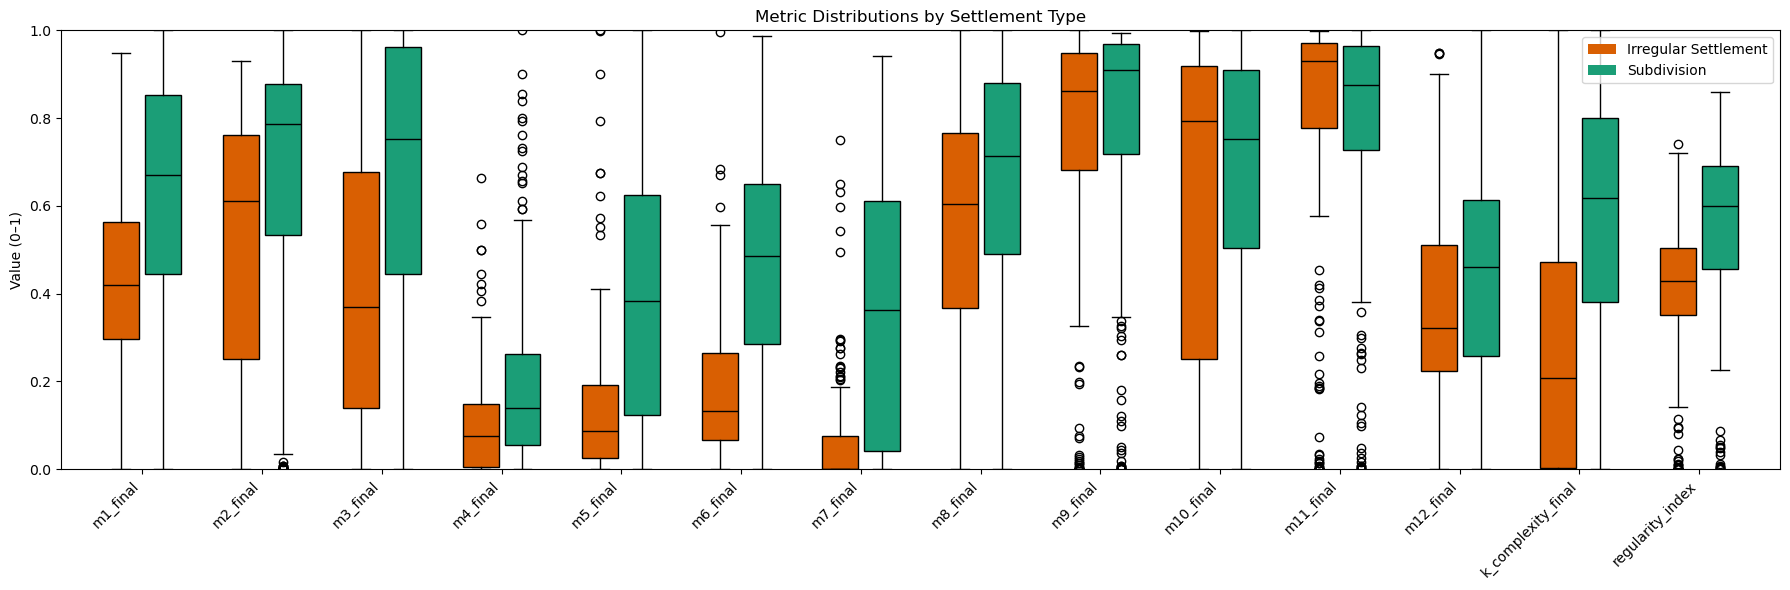

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 6))

positions = np.arange(len(metrics_order))
width = 0.35

ax.boxplot(
    data_irregular,
    positions=positions - width/2.,
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="#d95f02"),
    medianprops=dict(color="black"),
)

ax.boxplot(
    data_subdivision,
    positions=positions + width/2.,
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="#1b9e77"),
    medianprops=dict(color="black"),
)


'''
ax.boxplot(
    data_hybrid,
    positions=positions,
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor="#eaf602"),
    medianprops=dict(color="black"),
)
'''

# Axis formatting
ax.set_xticks(positions)
ax.set_xticklabels(metrics_order, rotation=45, ha='right')
ax.set_ylabel("Value (0–1)")
ax.set_ylim(0, 1)

# Legend (manual, matplotlib style)
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor="#d95f02", label="Irregular Settlement"),
    Patch(facecolor="#1b9e77", label="Subdivision"),
    #Patch(facecolor="#eaf602", label="Hybrid"),
]
ax.legend(handles=legend_handles, loc="upper right")

ax.set_title("Metric Distributions by Settlement Type")

plt.tight_layout()
plt.show()


In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

feature_cols = ['m1_final','m6_final','m2_final','m3_final','m4_final','m5_final','k_complexity_final'] #'m7_final','m8_final','m9_final',# 'm2_final','m3_final','m4_final','m25_final','m8_final','m9_final','k_complexity_final']

df = agg_to_validation[
    agg_to_validation['label_cat_subdivision_irregular'].isin(['Irregular Settlement', 'Subdivision'])
].copy()

y = df['label_cat_subdivision_irregular'].map({
    'Subdivision': 0,
    'Irregular Settlement': 1
})

X = df[feature_cols]
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# IMPORTANT: fit a fresh model on THIS X_scaled
logit = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000)
logit.fit(X_scaled, y)

coef = logit.coef_.ravel()  # length == len(feature_cols)

coef_table = pd.DataFrame({
    'feature': feature_cols,
    'coef': coef,
    'odds_ratio': np.exp(coef)
}).sort_values('coef', ascending=False)

coef_table


,feature,coef,odds_ratio
2,m2_final,0.943365,2.568610
3,m3_final,0.864775,2.374471
4,m4_final,0.052970,1.054398
6,k_complexity_final,-0.769347,0.463316
0,m1_final,-0.775662,0.460399
5,m5_final,-0.847361,0.428544
1,m6_final,-1.210759,0.297971


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Initialize and train the logistic regression model
logit = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
logit.fit(X_scaled, y)

# Coefficients of the model (feature importance)
coef_table = pd.DataFrame({
    'feature': feature_cols,
    'coef': logit.coef_[0],
    'odds_ratio': np.exp(logit.coef_[0])
}).sort_values('coef', ascending=False)

# Display coefficients and odds ratios
print(coef_table)

# Perform cross-validation to evaluate model performance (ROC-AUC)
roc_auc_scores = cross_val_score(logit, X_scaled, y, cv=5, scoring='roc_auc')
print(f"ROC-AUC: {roc_auc_scores.mean()} ± {roc_auc_scores.std()}")


              feature      coef  odds_ratio
2            m2_final  0.943365    2.568610
3            m3_final  0.864775    2.374471
4            m4_final  0.052970    1.054398
6  k_complexity_final -0.769347    0.463316
0            m1_final -0.775662    0.460399
5            m5_final -0.847361    0.428544
1            m6_final -1.210759    0.297971
ROC-AUC: 0.8305842448150139 ± 0.07492402147110347


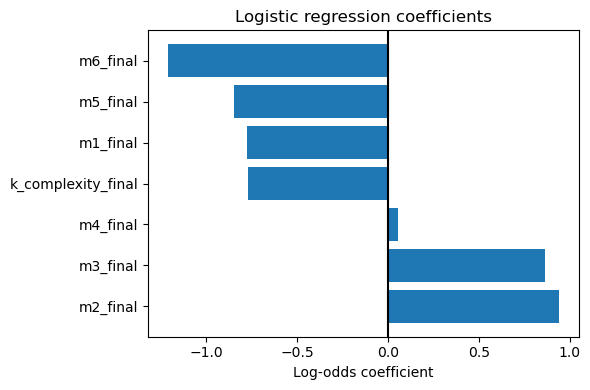

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(coef_table['feature'], coef_table['coef'])
plt.axvline(0, color='black')
plt.xlabel("Log-odds coefficient")
plt.title("Logistic regression coefficients")
plt.tight_layout()
plt.show()


In [46]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)   # intercept
logit_sm = sm.Logit(y, X_sm)

result = logit_sm.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.459838
         Iterations 7
                                  Logit Regression Results                                 
Dep. Variable:     label_cat_subdivision_irregular   No. Observations:                  523
Model:                                       Logit   Df Residuals:                      515
Method:                                        MLE   Df Model:                            7
Date:                             Wed, 17 Dec 2025   Pseudo R-squ.:                  0.3027
Time:                                     16:05:37   Log-Likelihood:                -240.50
converged:                                    True   LL-Null:                       -344.89
Covariance Type:                         nonrobust   LLR p-value:                 1.570e-41
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [47]:
'''
from cloudpathlib import S3Path

fs = s3fs.S3FileSystem(anon=False)

def s3_save(df, output_file, tmp_path, remote_path):
    os.makedirs(tmp_path, exist_ok=True)
    tmp_file = f"{tmp_path}/{output_file}"

    if output_file.endswith(".csv"):
        df.to_csv(tmp_file, index=False)
    elif output_file.endswith(".parquet") or output_file.endswith(".geoparquet"):
        df.to_parquet(tmp_file, index=False)
    else:
        raise ValueError("Unsupported file type for s3_save.")

    S3Path(remote_path).upload_from(tmp_file)
    os.remove(tmp_file)
    print(f"✅ Saved {remote_path}")


MAIN_PATH = "s3://wri-cities-sandbox/identifyingLandSubdivisions/data"
OUTPUT_PATH = f"{MAIN_PATH}/output"


out_file = f"agg_to_validation_{YOUR_NAME}.geoparquet"

s3_save(agg_to_validation, out_file, ".", OUTPUT_PATH)
'''

'\nfrom cloudpathlib import S3Path\n\nfs = s3fs.S3FileSystem(anon=False)\n\ndef s3_save(df, output_file, tmp_path, remote_path):\n    os.makedirs(tmp_path, exist_ok=True)\n    tmp_file = f"{tmp_path}/{output_file}"\n\n    if output_file.endswith(".csv"):\n        df.to_csv(tmp_file, index=False)\n    elif output_file.endswith(".parquet") or output_file.endswith(".geoparquet"):\n        df.to_parquet(tmp_file, index=False)\n    else:\n        raise ValueError("Unsupported file type for s3_save.")\n\n    S3Path(remote_path).upload_from(tmp_file)\n    os.remove(tmp_file)\n    print(f"✅ Saved {remote_path}")\n\n\nMAIN_PATH = "s3://wri-cities-sandbox/identifyingLandSubdivisions/data"\nOUTPUT_PATH = f"{MAIN_PATH}/output"\n\n\nout_file = f"agg_to_validation_{YOUR_NAME}.geoparquet"\n\ns3_save(agg_to_validation, out_file, ".", OUTPUT_PATH)\n'

In [48]:
agg_to_validation.columns

Index(['validation_id', 'Label', 'geometry', 'val_area', 'covered_area',
       'coverage_frac', 'city_name', 'on_network_street_length',
       'off_network_street_length', 'nearest_external_street',
       'building_count', 'k_complexity', 'max_radius', 'n_buildings',
       'sum_distance', 'n_closer_20m', 'has_buildings',
       'average_distance_nearest_building', 'm1_raw', 'm1_std', 'm2_raw',
       'm2_std', 'block_area', 'block_area_km2', 'built_area', 'index',
       'total_len_m', 'road_length', 'has_roads', 'n_intersections',
       'intersections_3plus', 'intersections_4way', 'has_intersections',
       'm3_raw', 'm3_std', 'm4_raw', 'm4_std', 'm5_raw', 'm5_std', 'm10_raw',
       'm10_std', 'm11_raw', 'm11_std', 'm12_raw', 'm12_std', 'm6_raw',
       'm6_std', 'm7_raw', 'm7_std', 'm8_raw', 'm8_std', 'm9_raw', 'm9_std',
       'k_complexity_raw', 'k_complexity_std', 'm1_final', 'm2_final',
       'm3_final', 'm4_final', 'm5_final', 'm10_final', 'm11_final',
       'm12_final'

In [49]:
agg_to_validation['label_cat_subdivision_irregular'].value_counts()

label_cat_subdivision_irregular
Non Residential         480
Subdivision             375
Open Area               363
Irregular Settlement    237
Hybrid                  231
Name: count, dtype: int64

In [50]:
from sklearn.svm import SVC

svm_linear = SVC(
    kernel='linear',
    C=1.0
)

svm_linear.fit(X_scaled, y)


coef = svm_linear.coef_.ravel()

svm_coef_table = pd.DataFrame({
    'feature': feature_cols,
    'coef': coef,
    'abs_coef': np.abs(coef)
}).sort_values('abs_coef', ascending=False)

svm_coef_table



,feature,coef,abs_coef
1,m6_final,-1.080544,1.080544
2,m2_final,0.890529,0.890529
0,m1_final,-0.683652,0.683652
6,k_complexity_final,-0.555578,0.555578
5,m5_final,-0.545512,0.545512
3,m3_final,0.488549,0.488549
4,m4_final,-0.052276,0.052276


In [51]:
scores = cross_val_score(
    svm_linear,
    X_scaled,
    y,
    cv=5,
    scoring='roc_auc'
)

print("Linear SVM ROC-AUC:", scores.mean(), "+/-", scores.std())


Linear SVM ROC-AUC: 0.831897863719726 +/- 0.0715673568030995


CORRELATIONS

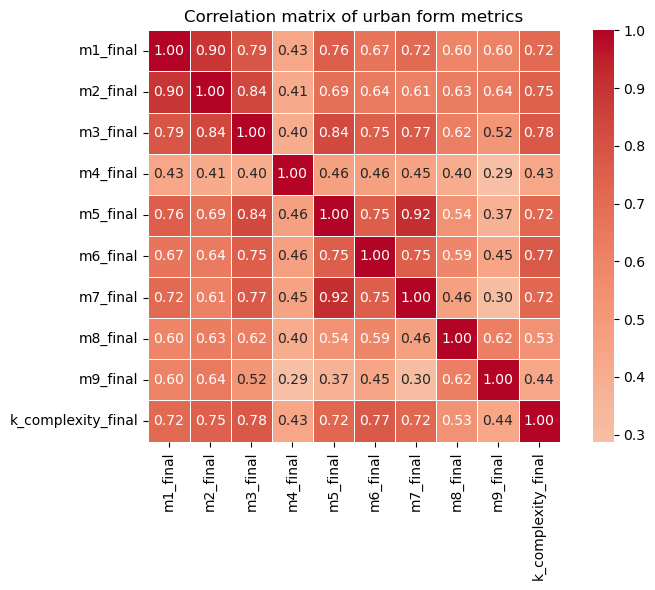

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

feature_cols = [
    "m1_final",
    "m2_final",
    "m3_final",
    "m4_final",
    "m5_final",
    "m6_final",
    "m7_final",
    "m8_final",
    "m9_final",
    "k_complexity_final",
]

X = df[feature_cols].copy()


X = X.dropna()


corr = X.corr(method="pearson")
corr



plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Correlation matrix of urban form metrics")
plt.tight_layout()
plt.show()


In [53]:
corr

,m1_final,m2_final,m3_final,m4_final,m5_final,m6_final,m7_final,m8_final,m9_final,k_complexity_final
m1_final,1.000000,0.897062,0.787320,0.431637,0.755403,0.668423,0.716767,0.595654,0.604625,0.715973
m2_final,0.897062,1.000000,0.838237,0.408772,0.686941,0.636820,0.613797,0.629209,0.644133,0.747166
m3_final,0.787320,0.838237,1.000000,0.403898,0.835337,0.752742,0.766591,0.623817,0.520621,0.776738
m4_final,0.431637,0.408772,0.403898,1.000000,0.463461,0.461150,0.451848,0.399230,0.287906,0.432206
m5_final,0.755403,0.686941,0.835337,0.463461,1.000000,0.750007,0.918538,0.536215,0.370351,0.720470
m6_final,0.668423,0.636820,0.752742,0.461150,0.750007,1.000000,0.753338,0.590498,0.446111,0.768549
m7_final,0.716767,0.613797,0.766591,0.451848,0.918538,0.753338,1.000000,0.461610,0.300670,0.719966
m8_final,0.595654,0.629209,0.623817,0.399230,0.536215,0.590498,0.461610,1.000000,0.616338,0.534664
m9_final,0.604625,0.644133,0.520621,0.287906,0.370351,0.446111,0.300670,0.616338,1.000000,0.436235
k_complexity_final,0.715973,0.747166,0.776738,0.432206,0.720470,0.768549,0.719966,0.534664,0.436235,1.000000


In [54]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

pca.explained_variance_ratio_


array([0.69760275, 0.10072851, 0.04905351, 0.04069371, 0.03164343,
       0.0281561 , 0.02090369, 0.01798672, 0.00689376, 0.00633781])

In [55]:
X

,m1_final,m2_final,m3_final,m4_final,m5_final,m6_final,m7_final,m8_final,m9_final,k_complexity_final
0,0.996723,0.954589,1.000000,0.000920,0.552225,0.500405,0.270420,0.742727,0.737186,0.606140
1,0.948111,0.930805,0.997310,0.000001,0.623127,0.475447,0.750540,0.951222,0.992082,0.203766
3,0.398842,0.377709,0.124361,0.050618,0.021584,0.024719,0.009321,0.592320,0.584722,0.010307
4,0.678582,0.822221,0.881944,0.217598,0.332421,0.348580,0.254913,0.672100,0.946239,0.298538
5,0.784054,0.850932,0.765280,0.263438,0.244883,0.348795,0.037654,0.708974,0.936376,0.420253
...,...,...,...,...,...,...,...,...,...,...
1676,0.617427,0.747195,0.708027,0.112292,0.203106,0.699343,0.211479,0.743133,0.855522,0.449221
1677,0.685160,0.752543,0.601725,0.015045,0.177172,0.278251,0.126013,0.692950,0.957798,0.459018
1679,0.517741,0.713340,0.705270,0.000097,0.169094,0.327437,0.101095,0.543736,0.975057,0.531117
1680,0.557621,0.805901,0.985372,0.400908,0.728163,0.447048,0.665258,0.992016,0.881679,0.831420


SVM

In [56]:
from sklearn.svm import LinearSVC

clf = LinearSVC(C=1.0, penalty="l2", dual=False)
clf.fit(X, y)

coef = pd.Series(clf.coef_[0], index=X.columns).sort_values()

coef


m7_final             -1.880398
m6_final             -1.709405
m1_final             -1.076955
k_complexity_final   -0.580546
m8_final              0.114337
m4_final              0.198963
m9_final              0.387344
m5_final              0.571650
m3_final              0.709999
m2_final              0.720510
dtype: float64

In [57]:
clf.classes_


array([0, 1])

In [58]:
import numpy as np
import pandas as pd

means = pd.DataFrame({
    "Irregular": X[y==0].mean(),
    "Subdivision": X[y==1].mean()
}).T

scores = means @ clf.coef_[0] + clf.intercept_[0]
scores


Irregular     -0.716359
Subdivision    0.204301
dtype: float64

In [59]:
df.groupby('label_cat_subdivision_irregular')[feature_cols].agg(['mean','median'])#.to_csv('subdivision_irregular_feature_means_medians.csv')

m1_final            m2_final            \
                                     mean    median      mean    median   
label_cat_subdivision_irregular                                           
Irregular Settlement             0.420993  0.419164  0.506152  0.611620   
Subdivision                      0.622840  0.671323  0.672525  0.787183   

                                 m3_final            m4_final            \
                                     mean    median      mean    median   
label_cat_subdivision_irregular                                           
Irregular Settlement             0.418532  0.369906  0.108812  0.075838   
Subdivision                      0.665002  0.753411  0.191474  0.140023   

                                 m5_final            m6_final            \
                                     mean    median      mean    median   
label_cat_subdivision_irregular                                           
Irregular Settlement             0.144093  0.087515  0.183619  0.132310   
Subdivision                      0.398021  0.383681  0.456287  0.486234   

                                 m7_final            m8_final            \
                                     mean    median      mean    median   
label_cat_subdivision_irregular                                           
Irregular Settlement             0.063476  0.000867  0.542281  0.603920   
Subdivision                      0.361251  0.362222  0.670623  0.714245   

                                 m9_final           k_complexity_final  \
                                     mean    median               mean   
label_cat_subdivision_irregular                                          
Irregular Settlement             0.738331  0.861619           0.266859   
Subdivision                      0.794365  0.909659           0.559850   

                                           
                                   median  
label_cat_subdivision_irregular            
Irregular Settlement             0.207576  
Subdivision                      0.616996

In [80]:
df['city_name'].value_counts().index

Index(['Bogota', 'Abidjan', 'Luanda', 'Cape_Town', 'Accra', 'Bamako',
       'Nairobi', 'Campinas', 'Lagos', 'Belo_Horizonte'],
      dtype='object', name='city_name')

In [82]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

feature_cols = [
    "m1_final",
    "m2_final",
    "m3_final",
    "m4_final",
    "m5_final",
    "m6_final",
    "m7_final",
    "k_complexity_final",
    "is_latam"
]

LATAM_CITIES = {
    "Bogota",
    "Campinas",
    "Belo_Horizonte"
}

AFRICA_CITIES = {
    "Abidjan",
    "Luanda",
    "Cape_Town",
    "Accra",
    "Bamako",
    "Nairobi",
    "Lagos"
}


df["is_latam"] = df["city_name"].isin(LATAM_CITIES).astype(int)

X = df[feature_cols].copy()

y = df['label_cat_subdivision_irregular'].map({
    'Subdivision': 1,
    'Irregular Settlement': 0
})



mask = X.notnull().all(axis=1)
X = X[mask]
y = y[mask]


X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

logit = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000
)

logit.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [83]:
from sklearn.metrics import log_loss
import numpy as np

# Predicted probabilities
p_model = logit.predict_proba(X_train_scaled)[:, 1]

# Log-likelihood of fitted model
ll_model = -log_loss(y_train, p_model, normalize=False)

# Log-likelihood of null model (intercept only)
p_null = np.full_like(y_train, y_train.mean(), dtype=float)
ll_null = -log_loss(y_train, p_null, normalize=False)

# McFadden pseudo-R2
r2_mcfadden = 1 - (ll_model / ll_null)

r2_mcfadden



0.3302023467319114

In [84]:
coef = pd.Series(
    logit.coef_[0],
    index=feature_cols
).sort_values()

coef


m3_final             -0.960836
m2_final             -0.487503
m4_final             -0.153702
m5_final              0.238799
m1_final              0.254472
is_latam              0.264072
k_complexity_final    0.481422
m6_final              0.998318
m7_final              1.521672
dtype: float64

In [85]:
y_val_pred = logit.predict(X_val_scaled)


In [86]:
cm = confusion_matrix(y_val, y_val_pred)
cm

cm_df = pd.DataFrame(
    cm,
    index=["Irregular (true)", "Subdivision (true)"],
    columns=["Irregular (pred)", "Subdivision (pred)"]
)

cm_df


,Irregular (pred),Subdivision (pred)
Irregular (true),33,16
Subdivision (true),17,65


In [87]:
print(classification_report(
    y_val,
    y_val_pred,
    target_names=["Irregular", "Subdivision"]
))


              precision    recall  f1-score   support

   Irregular       0.66      0.67      0.67        49
 Subdivision       0.80      0.79      0.80        82

    accuracy                           0.75       131
   macro avg       0.73      0.73      0.73       131
weighted avg       0.75      0.75      0.75       131



In [72]:
cm_df = pd.DataFrame(
    cm,
    index=["Irregular (true)", "Subdivision (true)"],
    columns=["Irregular (pred)", "Subdivision (pred)"]
)

cm_df


,Irregular (pred),Subdivision (pred)
Irregular (true),35,14
Subdivision (true),15,67


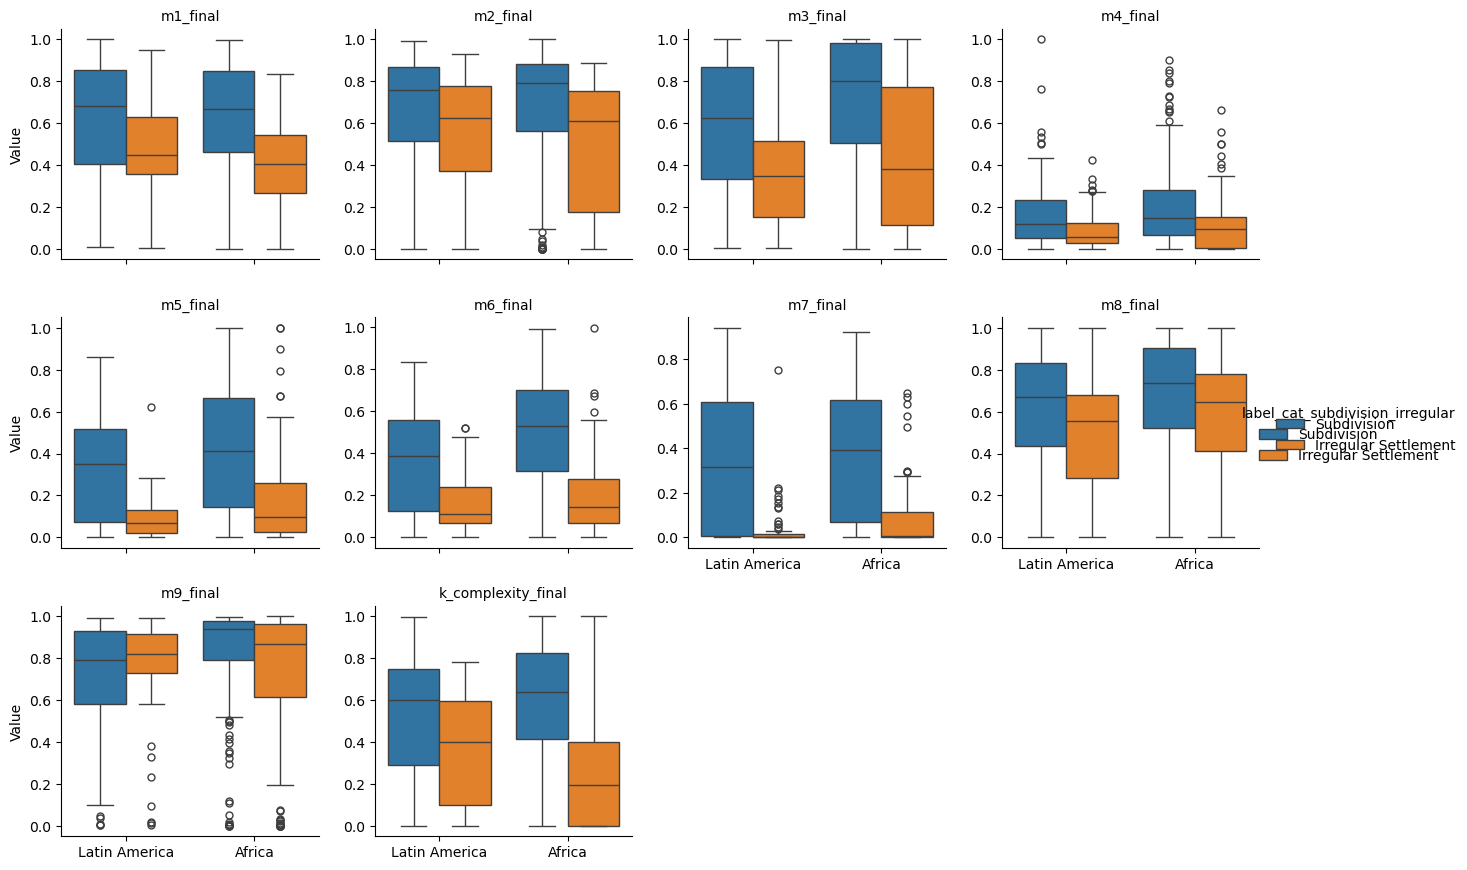

In [99]:
import pandas as pd

metrics = [
    'm1_final','m2_final','m3_final','m4_final','m5_final',
    'm6_final','m7_final','m8_final','m9_final','k_complexity_final'
]

plot_df = (
    df
    .loc[df[metrics + ['is_latam', 'label_cat_subdivision_irregular']].notnull().all(axis=1),
         metrics + ['is_latam', 'label_cat_subdivision_irregular']]
    .melt(
        id_vars=['is_latam', 'label_cat_subdivision_irregular'],
        value_vars=metrics,
        var_name='metric',
        value_name='value'
    )
)

plot_df['region'] = plot_df['is_latam'].map({
    1: 'Latin America',
    0: 'Africa'
})

g = sns.catplot(
    data=plot_df,
    x='region',
    y='value',
    hue='label_cat_subdivision_irregular',
    col='metric',
    kind='box',
    col_wrap=4,
    sharey=False,
    height=3,
    aspect=0.9
)

g.set_titles("{col_name}")
g.set_axis_labels("", "Value")
g.add_legend(title="")




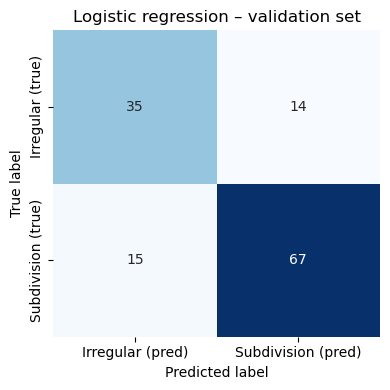

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Logistic regression – validation set")
plt.tight_layout()
plt.show()


In [67]:
print("Train accuracy:", logit.score(X_train_scaled, y_train))
print("Val accuracy:  ", logit.score(X_val_scaled, y_val))


Train accuracy: 0.7627551020408163
Val accuracy:   0.7786259541984732


In [68]:
agg_to_validation.columns

Index(['validation_id', 'Label', 'geometry', 'val_area', 'covered_area',
       'coverage_frac', 'city_name', 'on_network_street_length',
       'off_network_street_length', 'nearest_external_street',
       'building_count', 'k_complexity', 'max_radius', 'n_buildings',
       'sum_distance', 'n_closer_20m', 'has_buildings',
       'average_distance_nearest_building', 'm1_raw', 'm1_std', 'm2_raw',
       'm2_std', 'block_area', 'block_area_km2', 'built_area', 'index',
       'total_len_m', 'road_length', 'has_roads', 'n_intersections',
       'intersections_3plus', 'intersections_4way', 'has_intersections',
       'm3_raw', 'm3_std', 'm4_raw', 'm4_std', 'm5_raw', 'm5_std', 'm10_raw',
       'm10_std', 'm11_raw', 'm11_std', 'm12_raw', 'm12_std', 'm6_raw',
       'm6_std', 'm7_raw', 'm7_std', 'm8_raw', 'm8_std', 'm9_raw', 'm9_std',
       'k_complexity_raw', 'k_complexity_std', 'm1_final', 'm2_final',
       'm3_final', 'm4_final', 'm5_final', 'm10_final', 'm11_final',
       'm12_final'

In [69]:
agg_to_validation[agg_to_validation['label_cat_subdivision_irregular'].apply(lambda x: x in ['Irregular Settlement','Subdivision'])].groupby(['city_name','label_cat_subdivision_irregular']).agg('describe')[['m1_final', 'm2_final',
       'm3_final', 'm4_final', 'm5_final', 'm10_final', 'm11_final',
       'm12_final', 'm6_final', 'm7_final', 'm8_final', 'm9_final',
       'k_complexity_final']].transpose().to_csv('metrics_vs_labels_by_city.csv')